In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import numpy as np
from jaxtyping import Array, Float, PRNGKeyArray
import optax
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from diffrax import diffeqsolve, Dopri5, ODETerm

from sklearn.datasets import make_moons, make_blobs

## Make data

In [42]:
n_samples = 10000
n_cluster = 8
radius = 2.5
std = 0.2
centers = np.array(
    [
        np.array(
            [
                jnp.cos(2 * jnp.pi * i / n_cluster) * radius,
                jnp.sin(2 * jnp.pi * i / n_cluster) * radius,
            ]
        )
        for i in range(n_cluster)
    ]
)
blobs = make_blobs(
    n_samples=n_samples, n_features=2, centers=centers, cluster_std=std, random_state=42
)

moon = make_moons(n_samples=n_samples, noise=0.03, random_state=43)

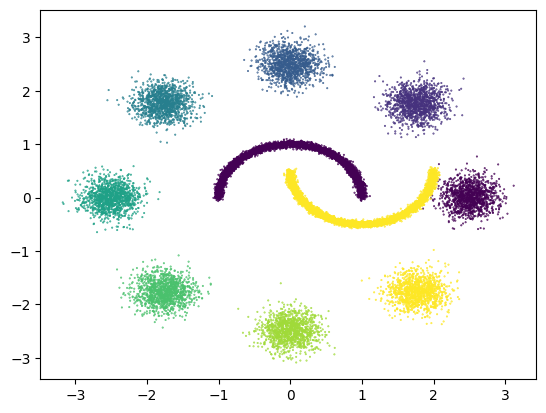

In [43]:
plt.scatter(blobs[0][:, 0], blobs[0][:, 1], c=blobs[1], s=0.2)
plt.scatter(moon[0][:, 0], moon[0][:, 1], c=moon[1], s=0.2)

## Choose pt and ut

In [44]:
def sample_conditional_pt(
    key: PRNGKeyArray,
    x0: Float[Array, "n_dim"],
    x1: Float[Array, "n_dim"],
    t: float,
    sigma: float,
):
    mu_t = t * x1 + (1 - t) * x0
    epsilon = jax.random.normal(key, mu_t.shape) * sigma
    return mu_t + epsilon

def compute_conditional_vector_field(x0: Float[Array, "n_dim"], x1: Float[Array, "n_dim"]):
    return (x1 - x0)

batch_sample_conditional_pt = jax.jit(jax.vmap(sample_conditional_pt, in_axes=(0, 0, 0, 0, None)))
batch_compute_conditional_vector_field = jax.jit(jax.vmap(compute_conditional_vector_field, in_axes=(0, 0)))

# Define model and training

In [81]:
key = jax.random.PRNGKey(9527)
sigma = 0.01
batch_size = 8000
learning_rate = 1e-3
n_dim = 2
width = 32
depth = 4

key, subkey = jax.random.split(key)
model = eqx.nn.MLP(n_dim+1, n_dim, key=subkey,width_size=width, depth=depth, activation=jax.nn.selu)
optimizer = optax.adam(learning_rate)
states = optimizer.init(eqx.filter(model, eqx.is_array))

dataset = TensorDataset(torch.tensor(blobs[0], dtype=torch.float32), torch.tensor(moon[0], dtype=torch.float32))
train_dataset, val_dataset = random_split(dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [82]:
n_epoch = 20000
@eqx.filter_jit
def loss(model, xt_with_t, ut):
    vt = jax.vmap(model)(xt_with_t)
    return jnp.mean(jnp.square(vt - ut))

for epoch in range(n_epoch):
    x0 = jnp.array(make_blobs(n_samples=batch_size, n_features=2, centers=centers, cluster_std=std, random_state=42+epoch)[0])
    x1 = jnp.array(make_moons(n_samples=batch_size, noise=0.03, random_state=43+epoch)[0])
    # for (x0, x1) in train_loader:
    #     x0 = jnp.array(x0)
    #     x1 = jnp.array(x1)

    key, subkey = jax.random.split(key)
    t = jax.random.uniform(subkey, (batch_size, ))
    key, subkey = jax.random.split(key)
    subkey = jax.random.split(subkey, batch_size)
    xt = batch_sample_conditional_pt(subkey, x0, x1, t, sigma)
    ut = batch_compute_conditional_vector_field(x0, x1)

    loss_values, grads = eqx.filter_value_and_grad(loss)(model, jnp.concatenate([xt, t[:, None]], axis=-1), ut)
    updates, states = optimizer.update(grads, states)
    model = eqx.apply_updates(model, updates)
    
    print(f"Epoch {epoch}, Loss: {loss_values}")


Epoch 0, Loss: 3.6693522930145264
Epoch 1, Loss: 3.614983081817627
Epoch 2, Loss: 3.4966187477111816
Epoch 3, Loss: 3.3519115447998047
Epoch 4, Loss: 3.324514627456665
Epoch 5, Loss: 3.22644305229187
Epoch 6, Loss: 3.18171763420105
Epoch 7, Loss: 3.0693678855895996
Epoch 8, Loss: 2.983581781387329
Epoch 9, Loss: 2.928743600845337
Epoch 10, Loss: 2.8782920837402344
Epoch 11, Loss: 2.7707998752593994
Epoch 12, Loss: 2.699443817138672
Epoch 13, Loss: 2.6716504096984863
Epoch 14, Loss: 2.5698022842407227
Epoch 15, Loss: 2.542853832244873
Epoch 16, Loss: 2.4571168422698975
Epoch 17, Loss: 2.4034039974212646
Epoch 18, Loss: 2.422668933868408
Epoch 19, Loss: 2.243077278137207
Epoch 20, Loss: 2.311204671859741
Epoch 21, Loss: 2.253929853439331
Epoch 22, Loss: 2.229329824447632
Epoch 23, Loss: 2.168773651123047
Epoch 24, Loss: 2.131427764892578
Epoch 25, Loss: 2.2094879150390625
Epoch 26, Loss: 2.194319009780884
Epoch 27, Loss: 2.1624879837036133
Epoch 28, Loss: 2.1861705780029297
Epoch 29, Los

In [83]:

test_samples = make_blobs(n_samples=10000, n_features=2, centers=centers, cluster_std=std, random_state=24)
test_samples = jnp.array(test_samples[0])

term = ODETerm(lambda t, x, args: model(jnp.concatenate([x, jnp.array([t])], axis=-1)))
solver = Dopri5()

@eqx.filter_jit
@eqx.filter_vmap
def transport(x):
    return diffeqsolve(term, solver, t0=0, t1=1, y0=x, dt0=1e-3)

In [84]:
transported_samples = transport(test_samples)

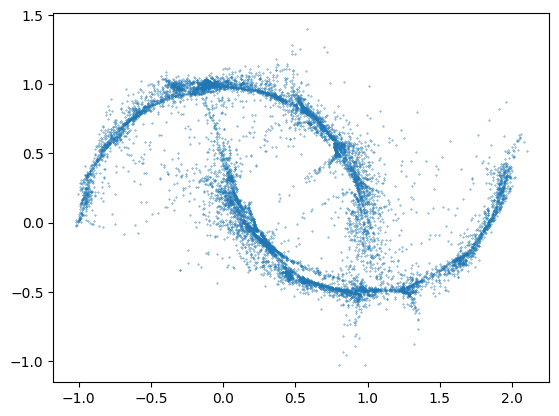

In [85]:
plt.scatter(transported_samples.ys[:,0,0],transported_samples.ys[:,0,1],s=0.1)

In [57]:
test_samples

Array([[-1.2520455 ,  1.7786139 ],
       [-1.6808097 ,  2.217827  ],
       [ 2.664375  , -0.02749469],
       ...,
       [ 2.4867096 , -0.52548987],
       [-1.8202344 , -1.8649571 ],
       [ 1.6640328 , -1.7790812 ]], dtype=float32)